Mark Evers<br>
mevers303@gmail.com<br>
https://githib.com/mevers303/missionmark

# MissionMark Document Sorting Proof of Concept
---

# Introduction
To sort the documents, we will be using a technique called Non-Negative Matrix Factorization (NMF).  NMF uses a term frequency/inverse document frequency (TF/IDF) matrix to discover "*latent topics*" within a corpus.  The number of latent topics to extract must be determined by the user.  I have created a couple of tools that will assist in choosing the number of topics to extract (not included in this demonstration, but you have seen them before).

What this process actually looks like is using a corpus to "train" a model to recognize a specified number of topics.  We will be using 42 topics in this demonstration.  Once we have a trained model, it can be used for two ultimate goals:
1. Determining how one or more documents relate to the latent topics.
2. Finding and listing documents that meet a certain criteria for topic relevancy.

There is a variety of ways to accomplish these two goals, with each way accomplishing it's own set of goals/criteria.

### About NMF
NMF uses an algorithm based in linear algebra to group the TF/IDF vectors.  The result is a model that relates each keyword to its relevancy in each topic that can be used to find the latent topics of any document in the corpus or any new documents it has never seen before.

### About Latent Topics
A latent topic is one that is not defined, but extracted based on how the TF/IDF keywords can be grouped in the training process.  The process is automatic and the only human input required is the *number* of topics to extract.  After they are created, these topics can be examined and labeled manually.
#### Advantages
 - The advantage to latent topics is that topics that the topics do not have to be known beforehand.  That would require us to read every single document in the corpus in order to manually pre-define every topic that may exist, which is exactly what we are trying to avoid.

#### Disadvantages
 - The topics are created purely by keyword; the meaning of each keyword is not taken into account.  This means that topics may be extracted based on keywords that are not relevant to our purpose, which is *types of work*.  In early tests, undesirable topics such as "US Army Corps of Engineers" were being found.  In the fbo_files database, documents that all contained the exact same, specific legal clause in the contract were being grouped even though the clause was not relevant to the type of work.<br><br>

 - **There is a simple solution!**<br>
   Well, two possible solutions:
  1. We can specify "stop words," which are words that are completely ignored in the entire process.  After extensive testing, I have found this to be the most effective solution.
  2. Another solution may be to only consider the "REQUIREMENTS" section of each document.  I did not find this to be effective, as a significant amount of relevent content was excluded from the more technical types of work (like *Computer Science*).
  
---

# Setup
#### Imports and definitions

In [1]:
import os, sys
sys.path.append(os.getcwd() + "/../src")

In [2]:
from pickle_workaround import pickle_load
from TfidfVectorizer import TfidfVectorizer
from vectorizer import tokenize, extract_requirements
from topics import search_models, plot_results
from data import get_query_corpus, get_connection

import numpy as np
import time
import datetime
import matplotlib.pyplot as plt

from sklearn.decomposition import NMF
from wordcloud import WordCloud

from jupyter_stuff import *

### TF/IDF
 - This section is more for technical intrigue, so you may want to skip to the 'How to use it' section to see what we can actually accomplish with this output.
 
A TF/IDF vector is generated for each document in the corpus.  TF/IDF is a technique used to weight the keywords of a document with relation to the corpus.  Each term is weighted inversely to its frequency within the corpus, meaning words that appear in a large number of documents (like 'contract') are not considered to be significant while words that appear in a small number of documents (like 'HVAC') are considered to be highly significant.

| | contract | hvac | engineering | ... |
| --- | --- | --- | --- | --- |
| **document 1** | 0.001 | 0.6 | 0 | ... |
| **document 2** | 0.001 | 0 | 0.75 | ... |
| **document 3** | 0.001 | 0.4 | 0.45 | ... |
| **...** | ... | ... | ... |  |

#### Load the corpus

In [3]:
_ = get_connection("/home/mark/Documents/missionmark/missionmark_db_creds")
query = """SELECT opportunity_id, program_description
           FROM import.govwin_opportunity
           WHERE program_description ILIKE('%REQUIREMENTS%')
        """
doc_ids, corpus = get_query_corpus(query, True)

tfidf = TfidfVectorizer(pickle_load("../output/CountVectorizer.pkl"), pickle_load("../output/TfidfTransformer.pkl"))
vocabulary = tfidf.get_feature_names()
print(len(vocabulary), "words")
print("Vectorizing documents...")
tfidf_corpus = tfidf.transform(corpus)
print(" -> Done!")

Connecting to Postgres database...
 -> Connection successful!
Loading corpus...
 -> 8851 documents loaded!
Loading ../output/CountVectorizer.pkl from cache...
 -> ../output/CountVectorizer.pkl loaded!
Loading ../output/TfidfTransformer.pkl from cache...
 -> ../output/TfidfTransformer.pkl loaded!
21327 words
Vectorizing documents...
 -> Done!                                                                       


---

# NMF Model
 - This section is more for technical intrigue, so you may want to skip to the 'How to use it' section to see what we can actually accomplish with this output.

The main usefulness of NMF comes in the form of two matrices.  The first is a matrix (H) of latent topics vs. key word strengths.  The second is a matrix (W) of documents vs. latent topic strengths.
#### The H matrix
The H matrix is pretty straightforward.  Each row represents a different latent topic and each column represents a keyword.  The contents of any individual cell contains the weight of a keyword within that topic.  It basically tells us which keywords are most important in identifying each topic.  One keyword may be relevant in identifying multiple different topics, or none at all.  What is most relevant for identifying a topic is the *set* of keywords it contains.

| | keyword_1 | keyword_2 | keyword_3 | ... |
| --- | --- | --- | --- | --- |
| **topic 1** | 0 | 0.5 | 0 | ... |
| **topic 2** | .75 | 0.1 | 0 | ... |
| **topic 3** | 0.2 | 0 | 0.8 | ... |
| **...** | ... | ... | ... |  |

#### The W matrix
The W matrix is what relates each individual document to the topics.  Each row represents one document, and each column is that document's strength in each topic.  A document commonly relates to multiple topics on varying degrees, but we usually only want to pick the strongest ones.  A new W matrix can quickly be generated for new documents/corpora in the future.  This ability is what will useful as more documents are added to the database.

| | topic 1 | topic 2 | topic 3 | ... |
| --- | --- | --- | --- | --- |
| **document 1** | 0 | 0.6 | 0 | ... |
| **document 2** | 0.1 | 0.1 | 0.55 | ... |
| **document 3** | 0.3 | 0.4 | 0 | ... |
| **...** | ... | ... | ... |  |

## Generate a model with 42 topics on the entire corpus
This produces a first level of 42  more general latent topics.  Some of these topics may be specific enough for our purposes, and some may not.  If we find a certain topic to be too general, we can build a second (or even more) level of sub-topics.  This will be covered later.

In [4]:
nmf = pickle_load("../output/NMF.pkl")

H = nmf.components_
H_normalized = H / H.max(axis=1).reshape((-1, 1))
W = nmf.transform(tfidf_corpus)
W_normalized = W / W.max(axis=0)

print("Found", H.shape[0], "topics")

Loading ../output/NMF.pkl from cache...
 -> ../output/NMF.pkl loaded!
Found 42 topics


---

# How to use it
Using these two innocuous matrices, a little human intuition, and a lot of linear algebra we can acheive a wide range of goals.  We will focus on a couple of different ways to identify new documents/contracts that a MissionMark customer may be interested in.  We will explore three ways to use this model:
1. **Searching using a desirable document as the search criteria**
 - Find all the topics relevant to this document
 - List other documents with a similar combination of topic relevancies.<br><br>
2. **Searching by keyword**
 - Find all topics where the keyword is relevant
 - List other documents within those topics.<br><br>
3. **Breaking down a large, broad topic into sub-topics**<br><br>
4. **Finding the topics within an SQL query**

<br>
**!!! Bear in mind that the percentages displayed from here on out are more for debugging purposes to be interpreted by a data scientist and do not necessarily represent an absolute strength, probability, certainty, confidence level, or anything like that. !!!**

# 1) Searching using a desirable document as the search criteria
One use for NMF is the ability use a known desirable document to search for other documents that are highly similar to it.

Here we will use a random document to find other documents that are related to it.  Using this technique, we can identify documents that have similar strengths to the original in each of the 42 topics.  This way we can find other topics that relate to the same unique combination of topics as the one we already know is desirable.  This is in contrast to searching based on relevancy to only a single topic, as demonstrated above.

#### Examine the document we know to be desirable (document #500)

In [5]:
doc_i = 500

doc = corpus[doc_i]
doc_topics = W_normalized[doc_i]
print("Relevant topics:")
[print(str(i).rjust(2), " = ", round(x * 100, 2), "%", sep="") for i, x in sorted(enumerate(doc_topics), key=lambda item: item[1], reverse=True) if x]
print("\nFULL TEXT:")
print(doc)

Relevant topics:
29 = 26.38%
34 = 25.55%
16 = 25.28%
 3 = 22.21%
40 = 21.02%
 2 = 13.2%
35 = 1.8%
37 = 1.46%
23 = 0.64%
14 = 0.61%
38 = 0.22%
21 = 0.19%
20 = 0.08%

FULL TEXT:
The Department of Army, Army Installation Management Command (IMCOM, may have a continuing requirement for scientific, engineering and technical expertise in support of the Environmental and Natural Resources Division (ENRD) and Engineering Plans and Services Division (EPSD) missions of the Directorate of Public Works at Fort Huachuca, Arizona.
PREVIOUS REQUIREMENTS:
Scientific, engineering and technical expertise in support of the Environmental and Natural Resources Division (ENRD) and Engineering Plans and Services Division EPSD) missions of the Directorate of Public Works at Fort Huachuca, Arizona
Tasks will generally fall within the areas of:
Analyses, studies, evaluation, and/or remediation of the effects of Fort Huachuca activities
Preparation of designs, reports, plans, and other required documents for ENR

### That's a lot of topics!
This document calls for "engineering and techical expertise in support of the Environmental and Natural Resources Division."  So maybe a MissionMark customer has expressed interest in this specific document, and would like to see other engineering contracts relating to environmental projects.

#### First let's look at the wordclouds of the topics that are most relevant to this document (29, 34, 16, 3, 40)

Topic 29


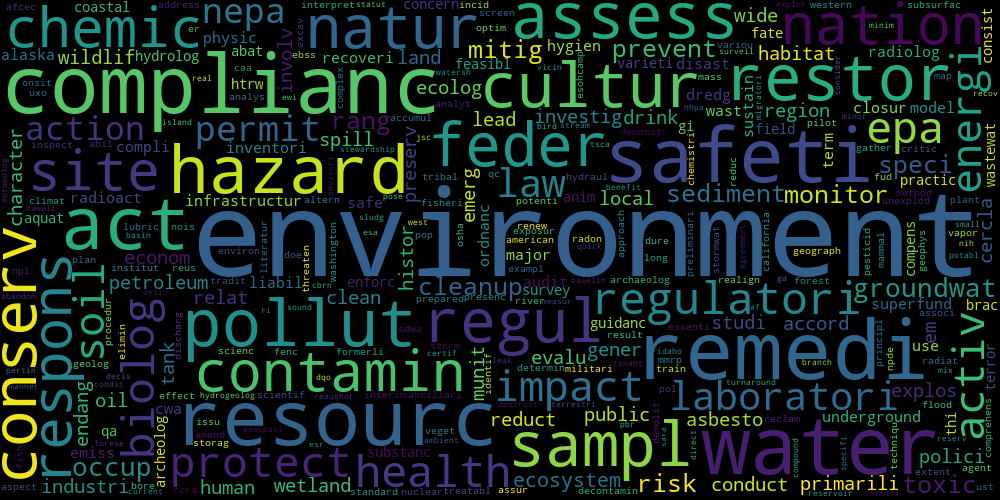


Topic 34


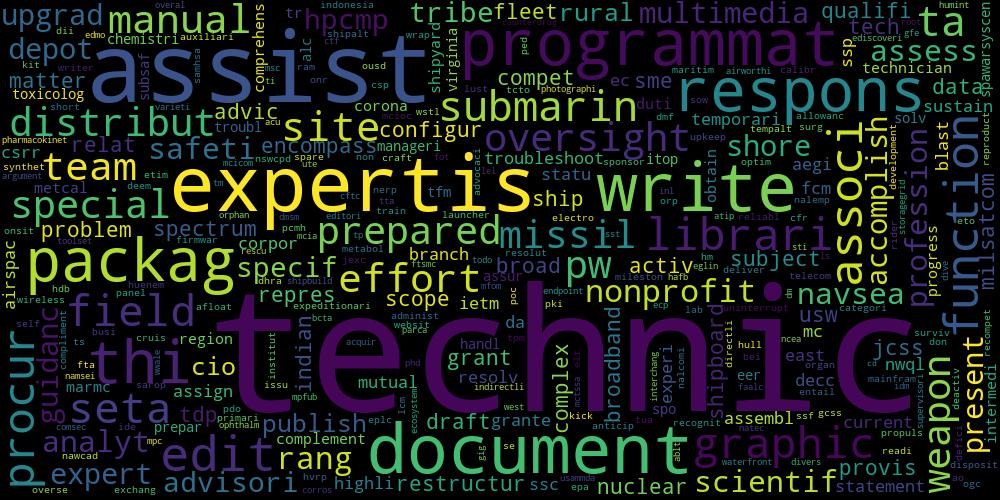


Topic 16


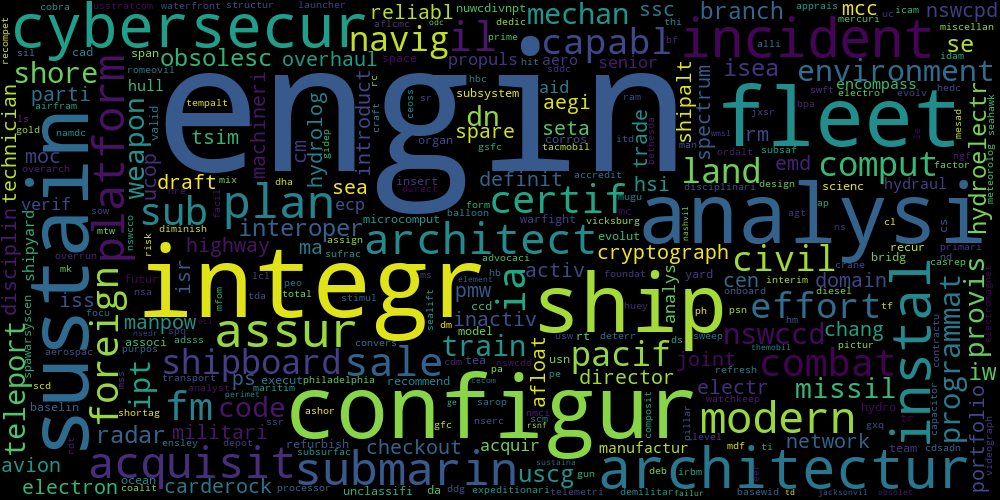


Topic 3


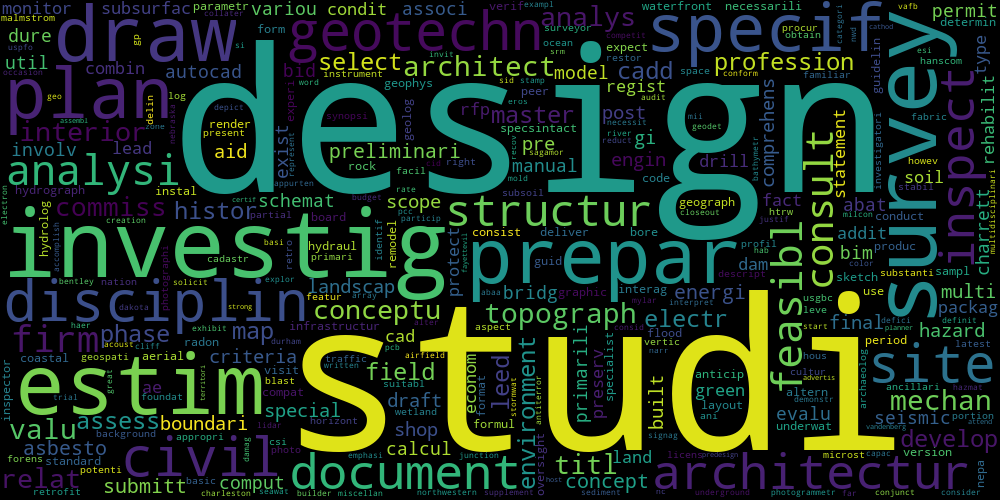


Topic 40


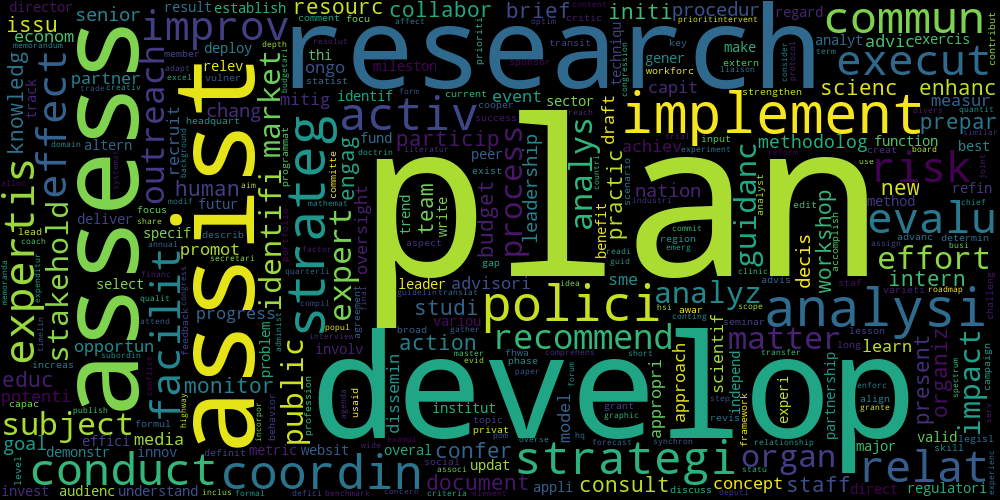

In [6]:
good_topics = [29, 34, 16, 3, 40]
for topic_i in good_topics:
    print("Topic", topic_i)
    display(Image(filename=f"../static/wordclouds/{topic_i}_nmf_wordcloud.png"))
    print()

Now that we have an idea of the type of documents we are looking for, let's look for other documents that relate strongly to the unique set of topics in document 500.

#### Find top 5 documents relevant to this one

In [7]:
from scipy.spatial.distance import cosine
distances = [cosine(W[doc_i], W[i]) for i in range(W.shape[0])]
best_matches = np.argsort(distances)[1:6]

print("DOCUMENTS MOST RELEVANT TO DOCUMENT #500\n")
for i in best_matches:
    print("*************************************")
    print(corpus[i])
    print()

DOCUMENTS MOST RELEVANT TO DOCUMENT #500

*************************************
The Department of the Army, US Army Corps of Engineers (USACE), Sacramento District, on behalf of the South Pacific Division (SPD), may have a continuing requirement for an Architect-Engineer (A-E) contract for the full spectrum of hydrologic and water management projects primarily in Northern and Central California.
PREVIOUS REQUIREMENTS
:
Architect-Engineer (A-E) contract for the full spectrum of hydrologic and water management projects
Full spectrum of hydrologic and water management analyses for water resource public works projects and environmental restoration projects
The projects may be in the preauthorization phase or authorized by Congress to proceed to construction
Services may also be used to support the Corps of Engineers (COE) during flood emergencies
A specific scope of work and services required will be issued with each task order
The end result of these studies/projects will be various repor

#### There they are!
For this demonstration we just picked the top 5.  We can also set a similarity threshold and find every document that meets the criteria as well (not demonstrated here).

---

## 2) Searching by keyword
We also are able to search the H matrix for one or more topics that are relevant to a specific keyword.  From there, we can identify all the documents relevant to those topics.  In the demonstration that follows, we will demonstrate this ability with the keyword "HVAC".  Once we know the relevant topics, we can then identify other documents that rank highly within those topics

#### Find topics where "hvac" is significant
Here I have created a function that finds all the topics where the weight for the term "HVAC" is not zero.  It only matters that we pick the ones with the higher percentages relative to the others in the list, so do not be discouraged that the highest is only displayed as 56.96%.

In [8]:
term_search("hvac", H_normalized, tfidf)

30 = 57.31%
13 = 41.62%
19 = 5.03%
 7 = 0.09%


We can see that the term "hvac" is most relevant in topics 13 and 31 by a significant amount, and topic 19 to a lesser degree.

### Explore topics
Let's explore the wordclouds and top 7 documents for each of these three topics.  I have created an auto-summarization function that displays only the two most significant sentences in terms of their respective topics.  **This is how any given latent topic can be manually labeled.**

#### Topic 30: General Construction, Repair, and Renovation
By examining the output found below, we can label this topic as "General Construction, Repair, and Renovation."  This topic is about general construction-heavy maintenance.  Recall that "HVAC" was the most related to this topic with a value of 57.931%.

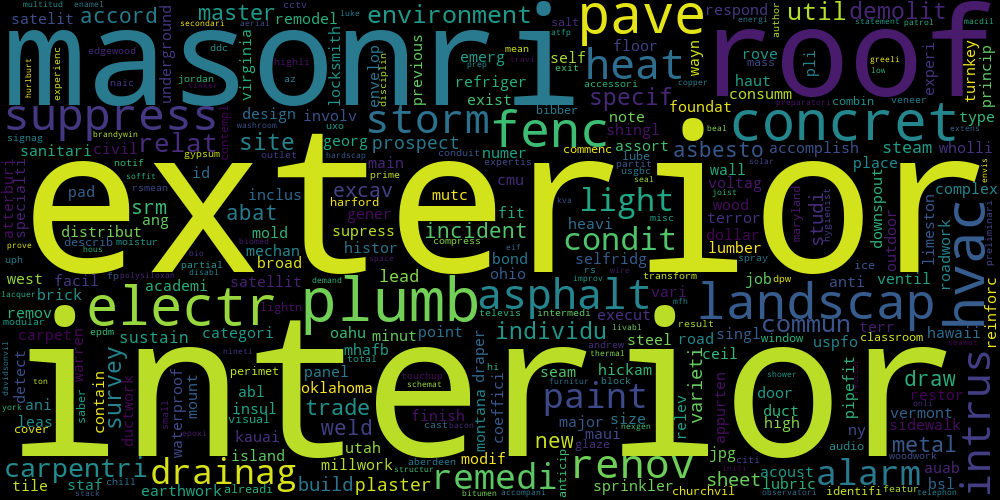

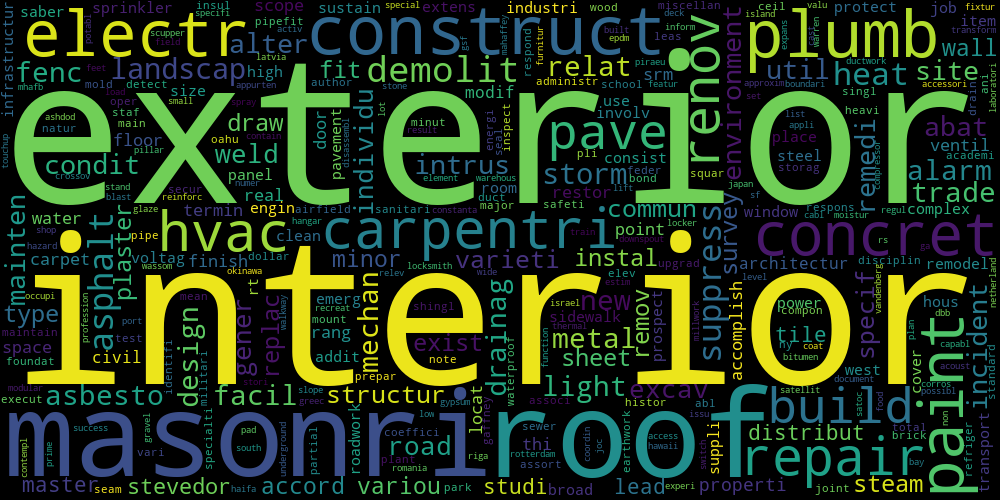

TOP 7 MOST RELEVANT DOCUMENTS (auto-summarized)

*************************************************************
129454 -> STRENGTH: 100.0%
The Department of the Army, National Guard Bureau (NGB), may have a continuing requirement for construction services in the state of Mississippi

PREVIOUS REQUIREMENTS:
Typical work includes, but is not limited to:
Interior and exterior renovations
Heating and air-conditioning
HVAC controls
Plumbing
Fire suppression
Interior and exterior electrical and lighting
Fire and intrusion alarms
Communications
Limited utilities
Site-work
Landscaping
Fencing
Masonry,
Roofing
Concrete
Asphalt paving
Storm drainage
Limited environmental remediation
Construction of new facilities
Surveys
Studies
Design-build
Other related work

*************************************************************
124026 -> STRENGTH: 95.46%
The Department of the Army, National Guard Bureau (NGB), has a requirement for maintenance, repair, construction, and design-build services at North C

In [9]:
topic_i = 30
top7(topic_i, W_normalized, corpus, doc_ids, tfidf, nmf)

___

#### Topic 13: Building Mechanical Systems Maintenance
By looking at the output below, we can label this topic as "Building Mechanical Systems Maintenance."  Recall that "HVAC" was the second most related to this topic with a value of 41.62%.

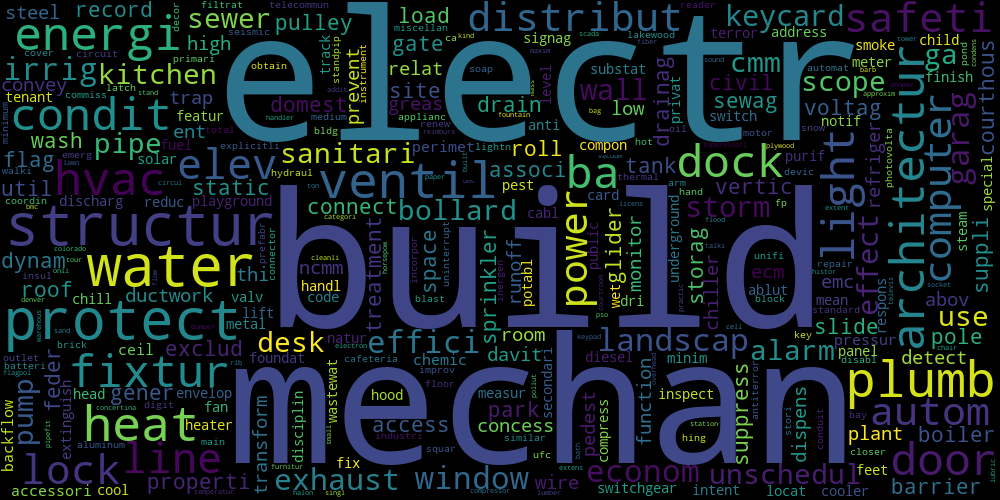

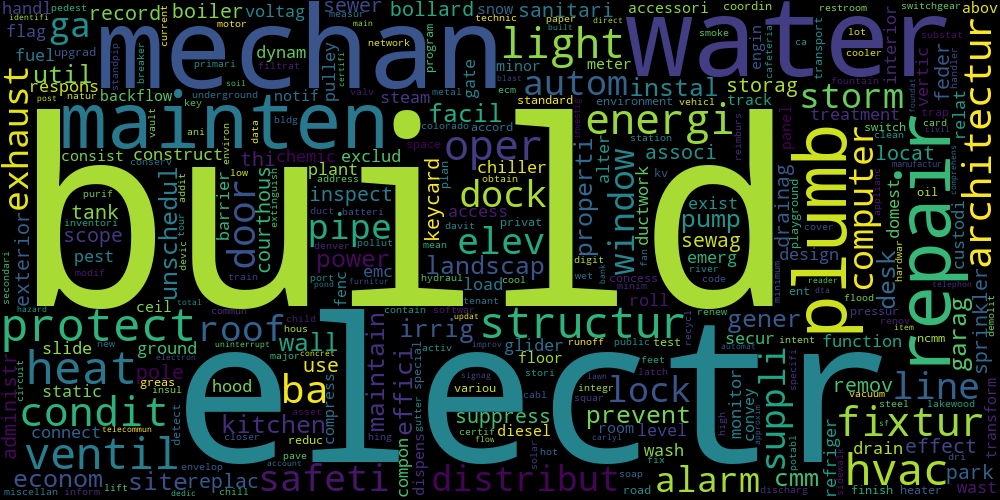

TOP 7 MOST RELEVANT DOCUMENTS (auto-summarized)

*************************************************************
165043 -> STRENGTH: 100.0%
REQUIREMENTS                                                                    
The Contractor shall provide management, supervision, labor, materials, equipment, and supplies and is responsible for the efficient, effective, economical, and satisfactory operation, scheduled and unscheduled maintenance, and repair of the equipment and components of the systems listed in C.1.1 located within the property line of the building(s): 50 United Nations Plaza Federal Building CA0093ZZ
System REQUIREMENTS:
Electrical systems and equipment

(3 Year Testing Due Nov 2020)
Mechanical, plumbing, and heating, ventilation, exhaust systems and air conditioning (HVAC) systems and equipment
Fire protection and life safety systems and equipment throughout the building(s), to include all kitchen and cafeteria space fire protection systems
All Control systems that are wit

PREVIOUS REQUIREMENTS                                                           
The requirements include providing all management, supervision, labor, materials, supplies, repair parts, tools and equipment necessary for the efficient, effective, economical, and satisfactory operation, scheduled and unscheduled maintenance, and repair of equipment and systems
This includes but is not limited to:
electrical systems and equipment
mechanical
plumbing
Heating, ventilation, exhaust systems and air conditioning (HVAC) systems and equipment
Fire protection and life safety systems and equipment (the inspection, testing, and maintenance of all fire protection systems)
Building Automation Systems (BAS)
Public address systems
Computerized lighting systems
Architectural and structural systems, fixtures, and equipment
Service request desk operations using a computerized maintenance management system (CMMS) if available or by other means as well as other administrative functions
Maintenance of lands

In [10]:
topic_i = 13
top7(topic_i, W_normalized, corpus, doc_ids, tfidf, nmf)

___

#### Topic 19:  General Building Maintenance
By looking at the output below, we can label this topic as "General Building Maintenance."  "HVAC" came up as related to this topic, but to a much lesser degree than topics 13 and 31.  This means that HVAC is relevant to this topic, but it is not highly specific to "General Building Maintenance."  This topic is more about lighter handyman type maintenance.  Recall that "HVAC" was the the least related to this topic with a value of 5.03%.

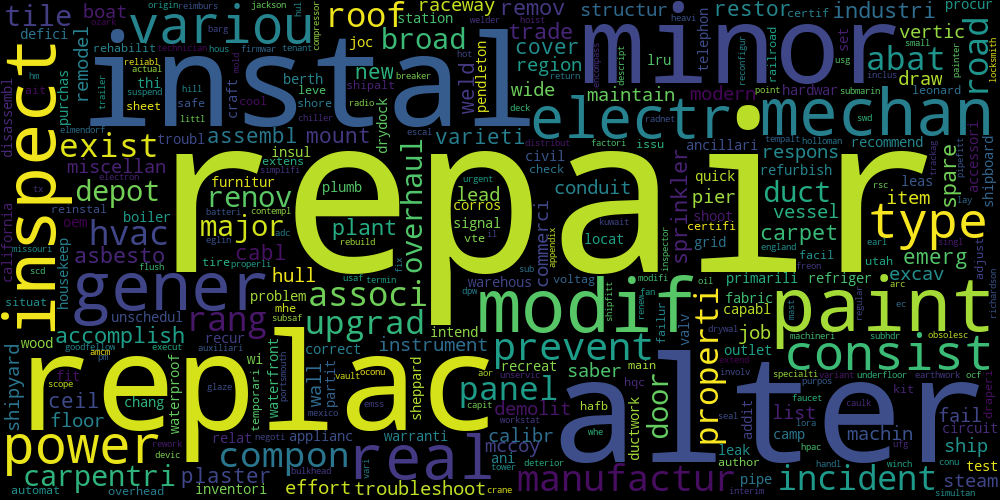

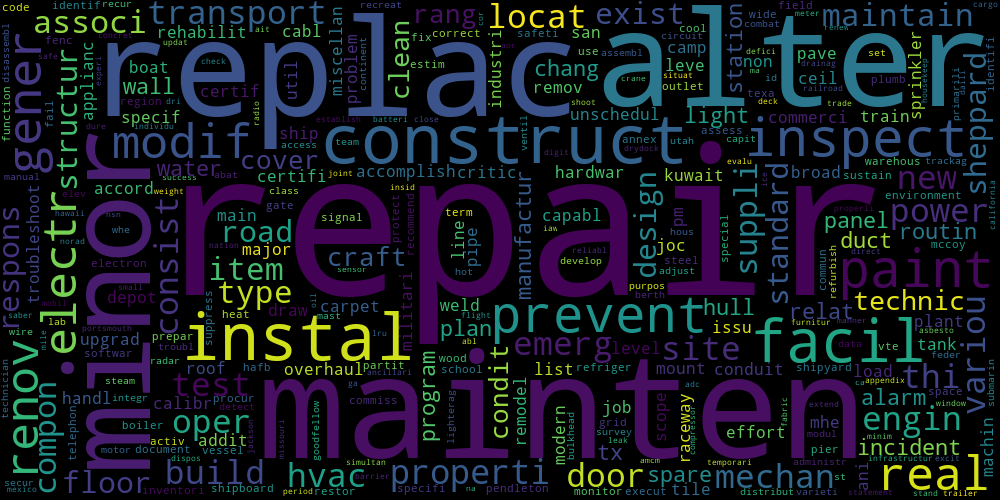

TOP 7 MOST RELEVANT DOCUMENTS (auto-summarized)

*************************************************************
167135 -> STRENGTH: 100.0%
The Department of the Army, Installation Management Command, may have a continuing requirement for maintenance and repair of real property and minor construction at Fort Gordon, Georgia

REQUIREMENTS
Consists of maintenance, repair, and alteration projects

*************************************************************
165459 -> STRENGTH: 90.77%
The General Services Administration, on behalf of the Department of the Air Force, Air Force Medical Service, Air Force Medical Support Agency has a continuing requirement for Medical Treatment Facility operations & maintenance

REQUIREMENTS
These facilities and systems require ongoing scheduled preventative maintenance, unscheduled service and repair, as well as minor construction (repair and alteration) work.

*************************************************************
130147 -> STRENGTH: 84.64%
PREVIOUS R

In [11]:
topic_i = 19
top7(topic_i, W_normalized, corpus, doc_ids, tfidf, nmf)

___

### Find other documents in Building Mechanical Systems Maintenance (#30)
Now that we know the topics most relevant to the term "HVAC", let's pick Building Mechanical Systems Maintenance and find all the other documents within this topic.

#### Pick a threshold to only chose the most relevant documents
As we covered before, any one topic will most likely be related to multiple topics on varying levels.  Some documents that happen to contain a couple of the other minorly relevant keywords for topic 13, but the document will not actually be about Building Mechanical Systems Maintenance.  We can eliminate these undesired documents from the list by specifying a relevancy threshold.

To help choose a threshold, we can look at the distribution of all the relevancy values.

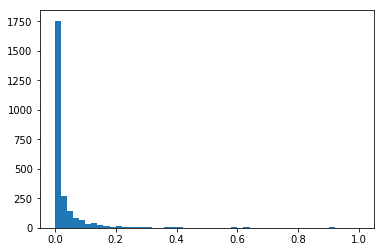

In [12]:
topic30 = W[:, 30]
topic30_normalized = topic30 / topic30.max(axis=0)
_ = plt.hist(topic30_normalized[topic30_normalized > 0.0], bins=50)

We usually want to choose the "elbow" of the graph, so in this case we will set the threshold to 0.08.  If we find that relevent documents are being excluded or irrelevent documents are being included, we can adjust the threshold up or down.

In [22]:
threshold = .06

topic30_i = topic30_normalized > threshold
topic30_tfidf = tfidf_corpus[topic30_i]
# topic30_corpus = corpus[topic30_i]
# topic30_doc_ids = doc_ids[topic30_i]

print(topic30_tfidf.shape[0], "documents relating to Building Mechanical Systems Maintenance.")

351 documents relating to Building Mechanical Systems Maintenance.


#### We found 351 documents within topic 30!

---

# 3) Breaking down a broad topic into sub-topics
When creating latent topics from across the entire database, we may find that some of the "general topics" or first-level topics are too broad.

### Computer Science (Topic #5)
The *Computer Science* topic seems to encompass a range of projects in specialized areas.  We can further group this broad topic into more specific sets of sub-topics.

Let's take a look at of what we're working with:

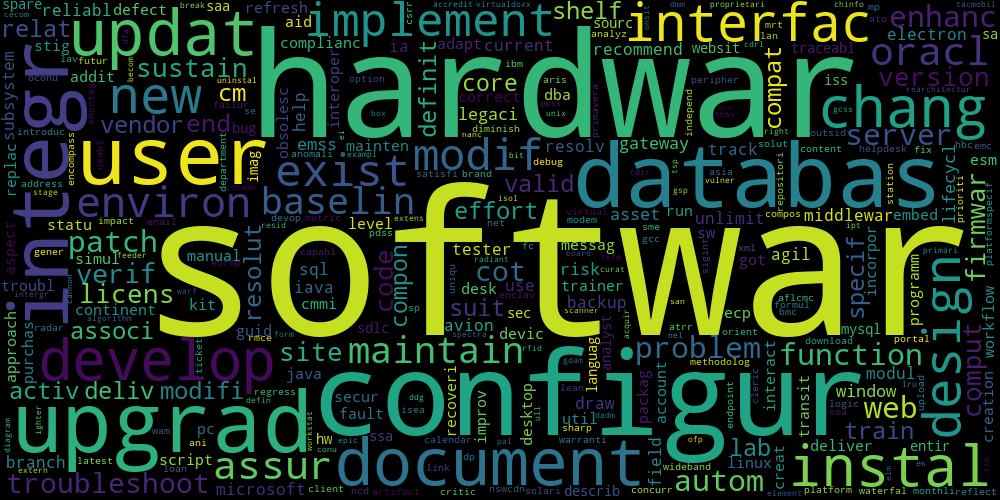

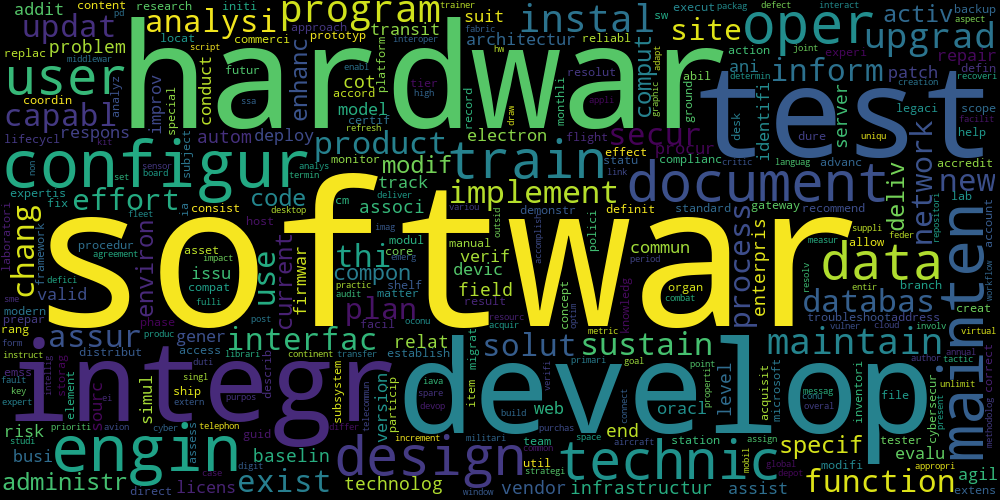

TOP 7 MOST RELEVANT DOCUMENTS (auto-summarized)

*************************************************************
138913 -> STRENGTH: 100.0%
The Department of Defense (DoD), Defense Logistics Agency (DLA), has a requirement for Managed Print Services Fleet Assessment Software

REQUIREMENTS:
The contractor shall:
Provide documentation on the hardware requirements to run the MPS software, in addition to, server space, network bandwidth, and other network resources or network software required to support the software
Provide an installation and configuration guide describing the mitigation or compliance of security standards
Provide annual software maintenance and technical support
Provide updates and patches to keep software compliant with future IA requirements
Diagnose and resolve problems that arise with the software
Provide training and materials
Provide on-site assistance to install and configure the software

*************************************************************
152576 -> STRE

In [14]:
topic_i = 33
top7(topic_i, W_normalized, corpus, doc_ids, tfidf, nmf)

#### It's clearly about Computer Science, but there are a lot of specialty areas within the topic
These documents all clearly outline contracts revolving around hardware, software, and digital technology in a broad sense.  We can also see that these documents cover a wide range of specialized fields within computer science.  Let's break this general topic down into more specific sub-topics:

#### Pick a threshold and find the relevant documents

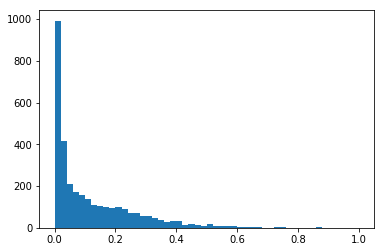

In [15]:
topic33 = W[:, 33]
topic33_normalized = topic33 / topic33.max(axis=0)
_ = plt.hist(topic33_normalized[topic33_normalized > 0.0], bins=50)

In [16]:
threshold = .2

topic33_i = topic33_normalized > threshold
topic33_tfidf = tfidf_corpus[topic33_i]
topic33_corpus = corpus[topic33_i]
topic33_doc_ids = doc_ids[topic33_i]

print(topic33_tfidf.shape[0], "documents relating to Computer Science.")

758 documents relating to Computer Science.


#### Create a new topic model with 7 latent topics from the Computer Science corpus

In [17]:
n_topics = 7
topic33_nmf = NMF(n_components=n_topics, max_iter=666, random_state=666)

topic33_W = topic33_nmf.fit_transform(topic33_tfidf)
topic33_W_normalized = topic33_W / topic33_W.max(axis=0)
topic33_H = topic33_nmf.components_
topic33_H_normalized = topic33_H / topic33_H.max(axis=1).reshape((-1, 1))

print(topic33_nmf.n_iter_, "iterations")

255 iterations


#### Explore the newly created latent topics

*************************************************************************************
*************************************************************************************
Latent Sub-Topic 0


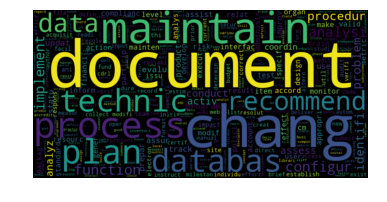

TOP 7 MOST RELEVANT DOCUMENTS (auto-summarized)

*************************************************************
109825 -> STRENGTH: 100.0%
Identify variances from the documented plan and recommend corrective actions and track implementation to meet site/unit activation planning milestones

Identify changes to individual support element requirements data and planning documents and provide recommended revisions

The contractor shall review and evaluate existing CM processes, procedures and functions and shall provide detailed recommendations for the addition, modification and/or elimination of those processes, procedures and/or functions in order to achieve improved program functionality, efficiency and effectiveness

*************************************************************
132883 -> STRENGTH: 92.41%
Develop, prepare, and update input to acquisition documents/briefings to ensure financial data is accurate and consistent with approved budget plans and key program events

Analyze finan

Systems Integrations: The Contractor shall identify and document data to ensure system, subsystem, equipment and component compatibility; identify and provide recommended solutions to interface problems; review and monitor system tolerances; perform system tests to assess performance, safety, operability, reliability and maintainability; and review engineering change proposals for impact on systems interface in accordance with Government furnished information

The Contractor shall initiate and complete original designs including modifications; identify and/or complete design validation testing; prepare technical data including product assurance and system safety requirements to establish configuration product baselines; prepare maintenance support documentation; and, review engineering changes, waivers and deviations for impact on design, performance, safety, and producibility for the programs

The Contractor shall identify existing Government sources of information, collect available 

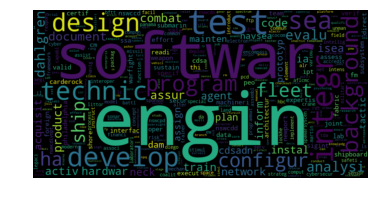

TOP 7 MOST RELEVANT DOCUMENTS (auto-summarized)

*************************************************************
155072 -> STRENGTH: 100.0%
The Department of the Navy, Naval Sea Systems Command, Naval Surface Warfare Center

Dahlgren Division, has a requirement for Engineering and Technical Support Services

REQUIREMENTS
The Contractor shall provide:
General Program Management and Administrative Services
Engineering Program and Project Management
Mission Systems Engineering, Concepts, and Capabilities
REQUIREMENTS Management
Interface Management
Command, Control, Communications, Computers, and Intelligence (C4I)
Security Engineering
Communications and Network Systems Engineering
Hardware Systems Engineering
In-Service Systems and Fleet Support
Systems Engineering for Test and Evaluation Activities
Systems Engineering for Software Development Activities
Software Engineering Analysis
Software Design and Development
System Test Analysis
System Testing
Hardware Testing
Configuration Manageme

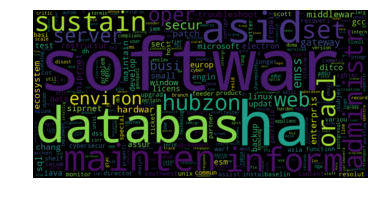

TOP 7 MOST RELEVANT DOCUMENTS (auto-summarized)

*************************************************************
165772 -> STRENGTH: 100.0%
The Department of Defense (DoD), Defense Information Systems Agency (DISA), has a requirement for an EcoSystem Sustainment Support for East and West- HUBZone Set Aside

Database administration support for COTS DISA internal and DISA mission partner database systems which are hosted on various operating systems, including (but not limited to) UNIX, LINUX, and Windows Servers residing on NIPRNet, SIPRNet, and Joint worldwide intelligence communications system environments on a 24x7x365 basis

These databases include various software and vendor packages, such as Oracle, Microsoft SQL Server, My SQL, PostgreSQL, and DB2 database technologies.

*************************************************************
165771 -> STRENGTH: 98.42%
The Department of Defense (DoD), Defense Information Systems Agency (DISA), has a requirement for an EcoSystem Sustainment Su

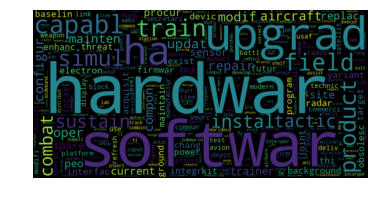

TOP 7 MOST RELEVANT DOCUMENTS (auto-summarized)

*************************************************************
164655 -> STRENGTH: 100.0%
MAINTENANCE/REPAIR/MODIFICATION/UPGRADE SERVICES                                
2

SITE VISITS
Maintenance/Repair/Modification/Upgrade Services consist of technical telephone support, trouble reporting, repair evaluations, parts repair, and on-site hardware and/or software problem support when required

On-site support may include software upgrades and the installation of new hardware due to equipment upgrades

*************************************************************
164766 -> STRENGTH: 91.72%
REQUIREMENTS                                                                    
AFTC/PZIE requires sustainment and technical support for existing Combat Electromagnetic Environment Simulators (CEESIM) and Synchronizer Controller Subsystems (SCS)
Sustainment and support is made up of the following activities/products/services:
MAINTENANCE/REPAIR/MODIFICAT

The Department of the Air Force, Air Force Materiel Command, Air Force Life Cycle Management Center, Mobility Directorate, C-130J Hercules Division, C-130J Program Branch has a requirement for C-130J Block 8.1 commercial kit installation

This robust platform has evolved into multiple mission-specific designs; referred to as “variants” for the remainder of this description
REQUIREMENTS
Kits are being fabricated and assembled that combine C-130J Block Updates 7.0 and 8.1 along with other incremental changes, referred to here as the Combined 8.1 Kit

Installation of the Combined 8.1 Kit adds these major capabilities to the C-130J weapon system: numerous software upgrades; new Communications, Navigation, and Identification System Processor (CNI-SP); Link-16; new control wheel; new Civil Global Positioning System (GPS); upgraded mission computer software; upgraded Data Transfer and Diagnostic System (DTADS) software; new Identification Friend or Foe (IFF) Transponder Mode 5 and Automatic D

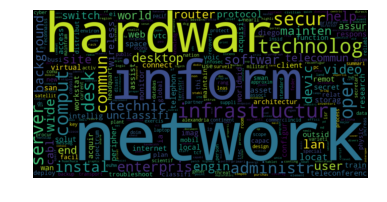

TOP 7 MOST RELEVANT DOCUMENTS (auto-summarized)

*************************************************************
17179 -> STRENGTH: 100.0%
SUMMARY                                                                         
The Space and Naval Warfare Systems Center, San Diego, Information Technology Division, may have a continuing requirement for support for newly identified Scientific and Technical (S&T) data network

BACKGROUND
The S&T network is a complex network of computing and communications systems and software providing available and stable access to timely information

REQUIREMENTS
The Scientific and Technical network environment includes these components:
Secret Wide Area Network (SWAN), which provides local secure (Secret) network connectivity
Unclassified Local Area Network (LAN)/Wide Area Network (WAN) computing
A telephone infrastructure
Video Teleconferencing (VTC) engineering
Worldwide scheduling
Bridging between 50-100 sites and operations
Information Security (InfoSec) pro

The Department of Transportation, Federal Highway Administration may have a continuing requirement for Western Federal Lands Highway Division's (WFLHD) Information Technology Support Services

PREVIOUS REQUIREMENTS
Required services include but are not limited to Desktop support services, Help Desk services, work infrastructure support, Web page development, Server and Networking support, Computer Aided Drafting software support, database management, IT warehouse operations, hardware/hardwire services, telecommunications services and software programming support

*************************************************************************************
*************************************************************************************
Latent Sub-Topic 5


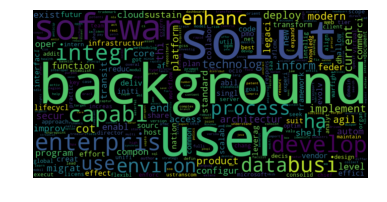

TOP 7 MOST RELEVANT DOCUMENTS (auto-summarized)

*************************************************************
113047 -> STRENGTH: 100.0%
The scope of the services required includes, but is not limited to:             
Program and project management
Engagement and facilitation of key stakeholders
Business Analysis and Requirement management
Application, service and cloud architecture support
Application and Service Design, Development, Implementation and Migration
Unit, System, User Acceptance and Automated Testing
User Interface / User Experience Design
Business Intelligence, dashboard and analytics support
Business process re-engineering and change management
Integration with databases and applications
Analytics and reporting•
Release management
Training support
Data Standardization, Quality, and Analytic Support Services
Platform Support and Disaster Recovery (DR)
User guides and system documentation
Agile Software Development Processes
Systems Engineering Lifecycle (SELC) Support
M

BACKGROUND:
The Federal Highway Administration (FHWA) anticipates an ongoing requirement for software development, integration support and professional Information Technology (IT) services

The Federal Highway Administration (FHWA) IT Support Services II (FITSS II) contract currently provides IT/digital support services, including software development and integration services for Commercial off the Shelf (COTS) products with customized software applications, database applications, and other solutions

VTC, FOIA, etc.)
REQUIREMENTS:
The FHWA has identified the following objectives for the FITSS follow-on requirement:
a) Transform software development from primarily waterfall to primarily agile
b) Promote innovation and deliver cost-effective and seamless IT solutions
c) Promote quality vendor performance in Non-Agile, Agile and DevOps environments
d) Stabilize and provide optimal service on legacy systems to employees, state DOTs and public users
e) Provide cost-effective, transparent o

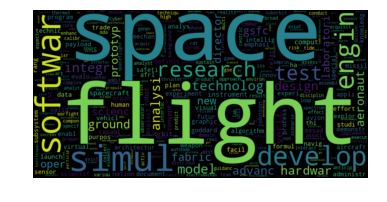

TOP 7 MOST RELEVANT DOCUMENTS (auto-summarized)

*************************************************************
141959 -> STRENGTH: 100.0%
The National Aeronautics and Space Administration (NASA), Goddard Space Flight Center (GSFC), may have a continuing requirement for Systems Engineering and Advanced Services (SEAS)

PREVIOUS REQUIREMENTS
Systems Engineering and Advanced Services
The purpose of the SEAS contract is to acquire engineering and related services to Mission Engineering and Systems Analysis Division (MESAD) and related organizations, as required, for the formulation, design, development, fabrication, integration, testing, verification, and operations of space flight and ground system hardware and software, including development and validation of new technologies to enable future space and science missions
The emphasis is on engineering services and will be in the areas of mission systems engineering and instrument systems engineering

***************************************

The National Aeronautics and Space Administration (NASA), Johnson Space Center (JSC), has a continuing requirement for simulation and software technology support to the Software, Robotics, and Simulation Division (SRSD)

SRSD is also responsible for providing engineering in the areas of Vehicle System Management (VSM), automation and intelligent systems, and tele-robotics and autonomous robotic systems for ground and space flight applications

PREVIOUS REQUIREMENTS
The contractor shall provide simulation and software technology support in the following fields:
Virtual Reality – includes research, design, and development of VR state-of-the-art technologies and software
Trick simulation environment – includes system administration duties that are required to facilitate the Trick development network and computer laboratory
Trick simulation math models and applications – includes simulation applications consisting of math models, verified simulations, and other supporting software utilitie

In [18]:
for topic_i in range(n_topics):
    print("*************************************************************************************\n*************************************************************************************")
    print("Latent Sub-Topic", topic_i)
    wc = WordCloud(background_color="black", max_words=333, width=1000, height=500)
    wc.fit_words({vocabulary[word_i]: topic33_H[topic_i, word_i] for word_i in range(topic33_H.shape[1]) if topic33_H[topic_i, word_i]})
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    top7(topic_i, topic33_W_normalized, topic33_corpus, topic33_doc_ids, tfidf, topic33_nmf, False, 3)

### We now have a new topic model (of sub-topic) with H and W matrices that we can use to employ every technique covered in this report!
I will let you explore the results yourself (above).

We can use the exact same techniques already covered and every technique that follows to search for documents and/or topics with this new model.
 - Searching by keyword
 - Using a specific document as a search criteria

---

# 4) Finding the topics within an SQL query
Instead of creating sub-topics from one of the latent topics created by an NMF model, we can do the same thing limited to a specific SQL query.

#### Select all documents containing the term '%engineer%'

In [19]:
query = """SELECT opportunity_id, program_description
           FROM import.govwin_opportunity
           WHERE program_description ILIKE('%engineer%')
        """
engineer_doc_ids, engineer_corpus = get_query_corpus(query, True)

print("Vectorizing documents...")
engineer_tfidf = tfidf.transform(engineer_corpus)
print(" -> Done!")

Loading corpus...
 -> 3202 documents loaded!
Vectorizing documents...
 -> Done!                                                                       


#### Create a new topic model with 12 latent topics from the 'engineer' corpus

In [20]:
n_topics = 12
engineer_nmf = NMF(n_components=n_topics, max_iter=666, random_state=666)

engineer_W = engineer_nmf.fit_transform(engineer_tfidf)
engineer_W_normalized = engineer_W / engineer_W.max(axis=0)
engineer_H = engineer_nmf.components_
engineer_H_normalized = engineer_H / engineer_H.max(axis=1).reshape((-1, 1))

print(engineer_nmf.n_iter_, "iterations")

191 iterations


#### Explore the newly created latent topics

*************************************************************************************
*************************************************************************************


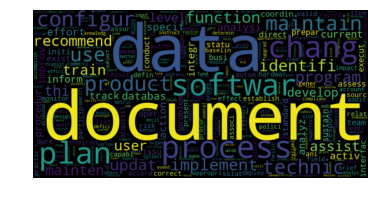

TOP 7 MOST RELEVANT DOCUMENTS (auto-summarized)

*************************************************************
109825 -> STRENGTH: 100.0%
Identify changes to individual support element requirements data and planning documents and provide recommended revisions

The contractor shall review and evaluate existing CM processes, procedures and functions and shall provide detailed recommendations for the addition, modification and/or elimination of those processes, procedures and/or functions in order to achieve improved program functionality, efficiency and effectiveness

*************************************************************
132883 -> STRENGTH: 95.39%
Collect and analyze data on existing PMA-234 business financial management procedures and patterns of performance, and recommend process improvements to ensure efficient/effective use of program resources

Coordinate with field activities to address identified fleet problems and develop potential improvements by implementation of design

The Contractor shall address their performance-based management procedures, which shall be established, maintained, and used in the performance of this contract to provide for:
Integration of work scope, schedule, and cost at all levels of management
Planning and control of work, schedule, and cost
Generation of timely, reliable, and auditable schedule, cost, and work performance information
Deliverables:
Program/Project Management Plan, (CDRL A001)
Integrated Master Schedule (IMS)
All scheduled work elements shall be integrated into one IMS

The Contractor shall develop a Configuration Management plan and report the CM status at PMRs
The Contractor shall perform and record internal Functional and Physical Configuration Audits (FCA/PCA), deliver those audit reports, and support FCAs/PCAs conducted by the Government as required
Deliverables:
Configuration Management Plan (CDRL A034)
Program Metrics
The Contractor shall establish, maintain, and use key performance metrics for the authori

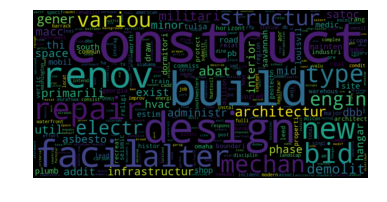

TOP 7 MOST RELEVANT DOCUMENTS (auto-summarized)

*************************************************************
138199 -> STRENGTH: 100.0%
The Department of the Navy, Navy Facilities Engineering Command, Mid-Atlantic, may have a continuing requirement for a Mechanical Construction Multiple Award Construction Contract for mechanical construction, alteration and repair to Government facilities in the North Carolina area

PREVIOUS
REQUIREMENTS:
The contractor shall provide design build or design bid build construction projects to various Government facilities throughout the state of North Carolina.

*************************************************************
148061 -> STRENGTH: 80.86%
The Department of the Army, Army Corps of Engineers (USACE), Savannah District, has a requirement for Design/Build Construction for General Repairs/Renovation within North Carolina and throughout the South Atlantic Division Area of Operations

PREVIOUS REQUIREMENTS:
General construction services on military

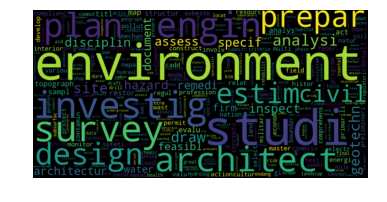

TOP 7 MOST RELEVANT DOCUMENTS (auto-summarized)

*************************************************************
123773 -> STRENGTH: 100.0%
PREVIOUS REQUIREMENTS                                                           
Projects will require multi-disciplined engineering services for commercial/industrial type facilities and aviation related structures

Services include, but are not limited to production of designs, plans, specifications, drawings, life cycle cost analysis, and cost estimates; conduct fact-finding studies, surveys, investigations; development of design criteria, standard designs and other professional A-E Services not necessarily connected with a specific construction project; and supervision/inspection of projects under construction
These services include:
Planning services, site, utility, infrastructure, traffic, and facility utilization and planning studies and analysis
Investigative services, topographic surveys, geotechnical analysis and reports, investigation of e

Title I services include all aspects of environmental design such as preparation and/or review of contract plans, specifications, scheduling, cost estimates, and preparation of operating and design manuals

These efforts include planning and programming, program management, scoping, studies, operations support (including data gathering and permit preparation), investigations (including geophysical), evaluations, consultations, conceptual design, value engineering, as well as operation, monitoring, and optimization of environmental treatment or control systems

*************************************************************
151702 -> STRENGTH: 86.83%
Work will include comprehensive A/E services including but not limited to preparation of full plans and specifications, preparation of design build requests for proposal, construction cost estimating, site investigations, analysis, planning, master planning, National Environmental Policy Act (NEPA) documentation, programming (1391), topograph

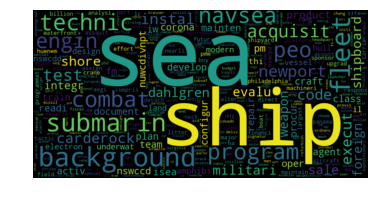

TOP 7 MOST RELEVANT DOCUMENTS (auto-summarized)

*************************************************************
152839 -> STRENGTH: 100.0%
Together, we engineer, build, buy and maintain ships, submarines and combat systems that meet the Fleet's current and future operational requirements

With a force of 60,000 civilian, military and contract support personnel, NAVSEA engineers, builds, buys and maintains the Navy's ships and submarines and their combat systems

*************************************************************
147362 -> STRENGTH: 98.0%
Together, we engineer, build, buy and maintain ships, submarines and combat systems that meet the Fleet's current and future operational requirements

With a force of 60,000 civilian, military and contract support personnel, NAVSEA engineers, builds, buys and maintains the Navy's ships and submarines and their combat systems

*************************************************************
101359 -> STRENGTH: 95.66%
Naval Sea Systems Command, Pr

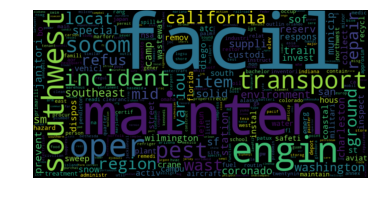

TOP 7 MOST RELEVANT DOCUMENTS (auto-summarized)

*************************************************************
163178 -> STRENGTH: 100.0%
The Department of the Navy, Naval Facilities Engineering Command, NAVFAC Southwest, has a project for ground maintenance, pavement clearance and integrated solid waste management

REQUIREMENTS
The Contractor shall:
furnish all labor, supervision, management, tools, materials, equipment, facilities, transportation, incidental engineering, operators and other items necessary to provide the services outlined below for various facilities services at several Naval and Marine Corps Installations.

*************************************************************
163096 -> STRENGTH: 98.08%
The Department of the Navy, Naval Facilities Engineering Command, NAVFAC Southwest, PW Contracts Utility, has a requirement to provide pest control and custodial services

REQUIREMENTS
The Contractor shall:
furnish all labor, supervision, management, tools, materials, equipme

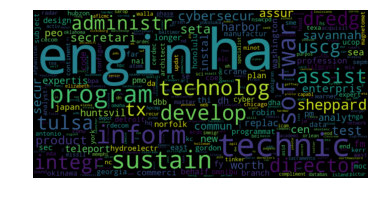

TOP 7 MOST RELEVANT DOCUMENTS (auto-summarized)

*************************************************************
131385 -> STRENGTH: 100.0%
The Department of Defense (DOD), Defense Information Systems Agency (DISA), has a requirement for Engineering and Installation Services

REQUIREMENTS:
The Contractor shall provide:
Engineering and installation services for new capabilities

*************************************************************
147853 -> STRENGTH: 94.49%
The Department of the Army, Army Materiel Command, Army Contracting Command, has a requirement for engineering and other technical services for Commercial Technologies

REQUIREMENTS:
Engineering and other technical services for Commercial Technologies.

*************************************************************
154252 -> STRENGTH: 75.91%
The Department of Defense, Defense Information Systems Agency has a requirement for engineering expertise in the areas of Information Assurance engineering; Software engineering; Systems en

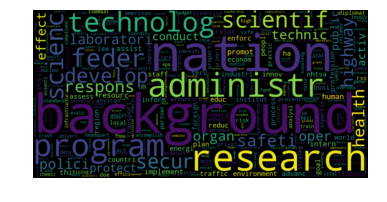

TOP 7 MOST RELEVANT DOCUMENTS (auto-summarized)

*************************************************************
159136 -> STRENGTH: 100.0%
BACKGROUND                                                                      
The National Highway Traffic Safety Administration's (NHTSA) mission is to save lives, prevent injuries, and reduce traffic-related health care and other economic costs

The agency develops, promotes, and implements effective educational, engineering, and enforcement programs with the goal of ending vehicle crash tragedies and reducing economic costs associated with vehicle use and highway travel

*************************************************************
51502 -> STRENGTH: 93.59%
REQUIREMENTS                                                                    
The US Department of Energy has the following REQUIREMENTS:
All management and operating responsibilities at the Pacific Northwest National Laboratory
Deliver the scientific knowledge and discoveries for DOE’s a

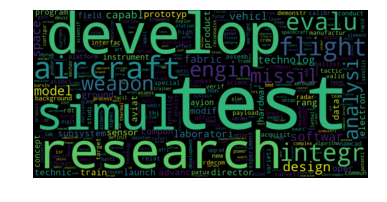

TOP 7 MOST RELEVANT DOCUMENTS (auto-summarized)

*************************************************************
105544 -> STRENGTH: 100.0%
REQUIREMENTS                                                                    
This contract provides the required research, engineering, and technical management for performing space technology concept development, analysis, development, integration, experimentation, demonstration, and evaluation in support of the AFRL/RV mission

The Government seeks engineering and technical effort in the following RISE activities:
Overarching Program Management
Program management, including attendance at technical meetings, reviews, off-sites, or technical conferences stated within TO specifications
Mission Design
Analytic modeling of enterprise objectives and how they translate to individual mission formulation
Systems engineering in support of scoping of requirements and translation into initial concept and preliminary designs
Implementation
Engineering, incl

This effort spans the functional operations areas of system engineering, system development, configuration management, target generation, controls, interfaces, simulator hardware/software, digital/analog simulations and component level ground testing, flight testing and wind tunnel facility support

The contractor shall provide system analysis and engineering support for development and operation of models and simulations to perform engineering analysis under the full range of Aviation and Unmanned Systems operational environments

*************************************************************
166174 -> STRENGTH: 88.49%
The Naval Research Laboratory may have a continuing requirement for the formulation, design, development, fabrication, integration, testing, verification, operation, and data analysis of spaceflight and ground system hardware and software

TDM may be issued to perform services in all aspects of mission and instrument development and implementation for components, subsyst

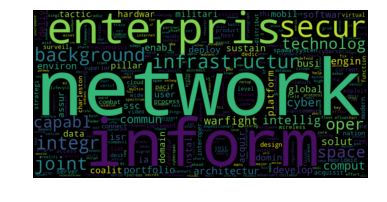

TOP 7 MOST RELEVANT DOCUMENTS (auto-summarized)

*************************************************************
75701 -> STRENGTH: 100.0%
The TCI Portfolio represents projects that deliver network capability, communication systems, large-scale base and building infrastructure and critical hosting services

REQUIREMENTS:
The TCI Portfolio encompasses Ashore, Afloat, Mobile, Joint, and Federal Infrastructure business areas to include:
Communications
Satellite and joint space communications
Networks
NETOPs
Network management
Common computing environment
Infrastructure to include:
All hardware and software components
Cloud computing
Afloat data centers and server hosting environments
Consolidated Afloat Network Enterprise Services (CANES) components
Wireless networking
The TCI Portfolio also encompasses the emerging environment in networking and computing:
The networking and computing environment includes all the utility components required to establish data centers and server hosting envir

SUMMARY:                                                                        
Multiple Contractors are fulfilling the Space and Naval Warfare Systems Command (SPAWAR), Charleston's requirement to develop a Pillar contracting strategy for small business set-aside competitiion centered around the business portfolios supported by the command for Cyber Intelligence Information Operations

REQUIREMENTS:
The Full and Open Cyber Intelligence Information Operations Portfolio Pillar will combine requirements from previously cancelled initiatives with the following services:
Program Management
Network Systems Security (NSS) Support
IA Certification, Test and Evaluation Support
Cryptographic Products Support
Systems Engineering, Architecture, Integration and Technical Support
Integrated Logistics (ILS) and Life Cycle Support
Sustainment Support Services
Operations Support
DMS REQUIREMENTS and Integration Support
Cyber Security and Homeland Defense Infrastructure Support
Secure Wireless Network

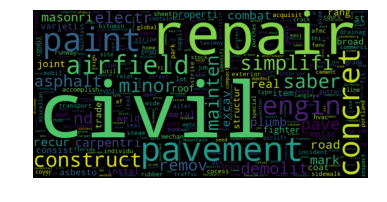

TOP 7 MOST RELEVANT DOCUMENTS (auto-summarized)

*************************************************************
135380 -> STRENGTH: 100.0%
The Department of the Air Force, Air Combat Command, 12th Air Force, 355th Fighter Wing, 355th Mission Support Group, 355th Civil Engineer Squadron may have a continuing requirement for a Simplified Acquisition of Base Engineering Requirements (SABER) contract

PREVIOUS REQUIREMENTS
The work to be performed will consist of a wide range of individual construction tasks to include, but not be limited to: carpentry, road and parking lot repair, roofing, excavating, interior and exterior electrical, steam fittings, plumbing, sheet metal, painting, demolition, concrete masonry and welding

*************************************************************
143153 -> STRENGTH: 85.72%
The Department of the Air Force, Air Combat Command (ACC), 9th Air Force, 325th Fighter Wing, 325th Mission Support Group, 325th Civil Engineer Squadron may have a recurring require

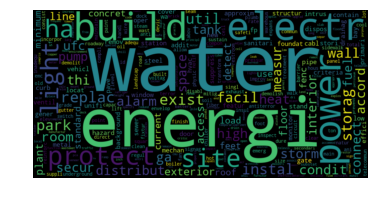

TOP 7 MOST RELEVANT DOCUMENTS (auto-summarized)

*************************************************************
164793 -> STRENGTH: 100.0%
REQUIREMENTS:                                                                   
Primary facilities include storage buildings with loading docks, covered storage shed, organizational vehicle parking, building information systems, fire protection and alarm systems, and Energy Monitoring and Control Systems (EMCS) connection, and installation of Intrusion Detection System (IDS), CCTV, and duress alarm

Supporting facilities include underground utilities (water, sewer, gas), electric service, parking and access roads, paving, sidewalks, curbs and gutters, sanitary sewer system, storm drainage, information systems, landscaping, site development, and site improvements

*************************************************************
119290 -> STRENGTH: 98.44%
REQUIREMENTS:                                                                   
The Contractor shal

Electrical systems include:                                                     
primary power distribution, lighting, energy monitoring/control systems, intrusion detection system, telephone/data switch/server rooms, photovoltaic cells, electrical switch gear, transformers, circuits, and fire alarms

Site work will include:
building utility systems, traffic control, parking, domestic water, fire protection water, sanitary sewer, sewage conveyance, propane gas networks, perimeter security fencing, gates, storm water management, fiber/copper communications, cable television, and area lighting.

*************************************************************
155099 -> STRENGTH: 86.67%
The renovation also includes replacement of mechanical and electrical systems including controls, chilled water system, air handling system, fire protection, clean room and laboratory systems (water, gas, ventilation, pressurization, and filtration), lighting, power and electrical distribution

Work component

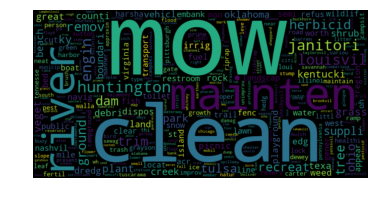

TOP 7 MOST RELEVANT DOCUMENTS (auto-summarized)

*************************************************************
164932 -> STRENGTH: 100.0%
The Department of the Army, Army Corps of Engineers (USACE), Louisville District, may have a continuing requirement for mowing and maintenance services at Green River Lake

PREVIOUS REQUIREMENTS:
The Contractor shall furnish all supplies, tools, equipment, and labor necessary for the contractor to perform mowing and maintenance services at Green River Lake

*************************************************************
140397 -> STRENGTH: 97.44%
The Department of the Army, US Army Corps of Engineers (USACE), Louisville District, may have a continuing requirement for Mowing and Maintenance Services at WH Harsha Lake, Ohio

PREVIOUS REQUIREMENTS:
Contractor shall furnish all necessary management, personnel, materials, supplies, tools, equipment, fuel and vehicles, except as otherwise provided, required to perform cleaning, maintenance, and mowing servic

In [21]:
for topic_i in range(n_topics):
    print("*************************************************************************************\n*************************************************************************************")
    wc = WordCloud(background_color="black", max_words=333, width=1000, height=500)
    wc.fit_words({vocabulary[word_i]: engineer_H[topic_i, word_i] for word_i in range(engineer_H.shape[1]) if engineer_H[topic_i, word_i]})
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    top7(topic_i, engineer_W_normalized, engineer_corpus, engineer_doc_ids, tfidf, engineer_nmf, False, 2)

### We now have a new topic model (of sub-topics within the SQL '%engineer%' query) with H and W matrices that we can use to employ every technique covered in this report!
I will let you explore the results (above) yourself.

We can use the exact same techniques already covered and every technique that follows to search for documents and/or topics with this new model.
 - Searching by keyword
 - Using a specific document as a search criteria

---

# Summary
We can use NMF in various ways to achieve three main purposes:
1. Discovering a number of latent topics within a corpus.
2. Finding how a document or set of documents relates to the latent topics discovered.
3. Finding and listing documents that meet a certain criteria.

Using this information, we can use a variety of techniques to label documents and/or search for other related documents.  You can apply what you've seen here to any other combination of scenarios.  This demonstration was meant to show you the capabilities so you can imagine how it can be applied to other situations.  There are even more possibilities than those covered here.

I would like to learn more about MissionMark's process in assisting its customers to indentify other tasks that this can be used for.  I bet there are some areas where this NMF technique will be of use that you are not aware of and therefore do not know to ask for!